In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Define your dataset path from Google Drive (adjust accordingly)
path = "/content/drive/My Drive/Model_path/student_6_6_3072_model_final.pth"


Mounted at /content/drive


# **CoLA**

In [2]:
!pip install datasets transformers

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00


In [3]:
!pip install datasets --upgrade

In [4]:
!pip uninstall datasets
!pip install datasets

Found existing installation: datasets 3.0.1
Uninstalling datasets-3.0.1:
  Would remove:
    /usr/local/bin/datasets-cli
    /usr/local/lib/python3.10/dist-packages/datasets-3.0.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/datasets/*
Proceed (Y/n)? y
  Successfully uninstalled datasets-3.0.1
  Using cached datasets-3.0.1-py3-none-any.whl.metadata (20 kB)
Using cached datasets-3.0.1-py3-none-any.whl (471 kB)


In [5]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00


# ***CoLA***

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1063 [00:00<?, ? examples/s]

<ipython-input-14-c9ebb23b1a88>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Epoch,Training Loss,Validation Loss,Matthews Correlation,Accuracy,Precision,Recall,F1
1,0.610400,0.614973,0.000000,0.691275,0.691275,1.000000,0.817460
2,0.590700,0.621806,0.049848,0.692234,0.693424,0.994452,0.817094
3,0.532200,0.650565,0.034246,0.658677,0.696872,0.895978,0.783981
4,0.496000,0.767682,0.041195,0.653883,0.698675,0.877947,0.778119
5,0.453100,0.755008,0.047651,0.648130,0.700680,0.857143,0.771054
6,0.412900,0.835825,0.080190,0.629914,0.712294,0.779473,0.744371


ValueError: x and y must have same first dimension, but have shapes (12,) and (6,)

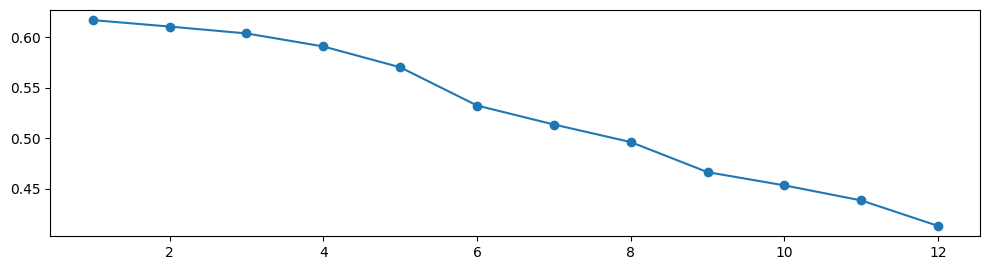

In [ ]:

import torch
from transformers import BertConfig, BertForSequenceClassification, BertTokenizerFast
from transformers import TrainingArguments, Trainer, TrainerCallback, EvalPrediction
from datasets import load_dataset
import evaluate  # Use evaluate for metrics instead of load_metric
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset and Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = load_dataset("glue", "cola")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Create Custom Student Model for CoLA
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased", num_labels=2)  # Binary classification
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6  # Reduce the number of layers for a smaller model
    student_config.intermediate_size = 3072
    return BertForSequenceClassification(student_config)

student_model = create_custom_student_model().to(device)

# Load Model State Dict from Google Drive (Updated model path)
# Make sure to replace with your actual model path in Google Drive
model_path = '/content/drive/My Drive/Model_path/student_6_6_3072_model_final.pth'
state_dict = torch.load(model_path, map_location=device)

# Filter the state dictionary to ensure compatibility
new_state_dict = {}
for key, value in state_dict.items():
    if key.startswith("bert.") or key.startswith("classifier."):
        new_state_dict[key] = value

student_model.load_state_dict(new_state_dict, strict=False)

# Training Arguments and Trainer Setup
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    eval_strategy="epoch",
    logging_dir='./logs_cola',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results_cola',
    load_best_model_at_end=True,
    metric_for_best_model="matthews_correlation",
    save_strategy="epoch",
    report_to="none",  # Disable default reporting to remove unnecessary logging
)

# Define Metrics Calculation using evaluate
matthews_metric = evaluate.load("matthews_correlation")

def compute_metrics(p: EvalPrediction):
    preds = torch.tensor(p.predictions)
    preds = torch.argmax(preds, dim=1)

    # Compute metrics using sklearn
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary')
    acc = accuracy_score(p.label_ids, preds)

    # Compute Matthews Correlation
    matthews_corr = matthews_metric.compute(predictions=preds, references=p.label_ids)["matthews_correlation"]

    return {
        "matthews_correlation": matthews_corr,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Define Trainer Callback for Metrics Logging
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {"train_loss": [], "eval_loss": [], "matthews_correlation": [],
                        "accuracy": [], "precision": [], "recall": [], "f1": []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.metrics["train_loss"].append(logs["loss"])
            if "eval_loss" in logs:
                self.metrics["eval_loss"].append(logs["eval_loss"])
            if "eval_matthews_correlation" in logs:
                self.metrics["matthews_correlation"].append(logs["eval_matthews_correlation"])
            if "eval_accuracy" in logs:
                self.metrics["accuracy"].append(logs["eval_accuracy"])
            if "eval_precision" in logs:
                self.metrics["precision"].append(logs["eval_precision"])
            if "eval_recall" in logs:
                self.metrics["recall"].append(logs["eval_recall"])
            if "eval_f1" in logs:
                self.metrics["f1"].append(logs["eval_f1"])

metrics_callback = MetricsCallback()

# Set up Trainer
trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]
)

# Train and Evaluate the Model
trainer.train()

# Plot the Metrics
def plot_metrics(metrics):
    plt.figure(figsize=(12, 10))
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.subplot(3, 1, 1)
    plt.plot(epochs, metrics["train_loss"], label="Training Loss", marker='o')
    plt.plot(epochs, metrics["eval_loss"], label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(epochs, metrics["matthews_correlation"], label="Matthews Correlation", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Matthews Correlation")
    plt.legend()
    plt.title("Matthews Correlation Over Epochs")
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy", marker='o')
    plt.plot(epochs, metrics["precision"], label="Precision", marker='o')
    plt.plot(epochs, metrics["recall"], label="Recall", marker='o')
    plt.plot(epochs, metrics["f1"], label="F1 Score", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.title("Accuracy, Precision, Recall, and F1 Score Over Epochs")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(metrics_callback.metrics)


# ***Sts-b***

In [ ]:

import torch
from transformers import BertConfig, BertForSequenceClassification, BertTokenizerFast
from transformers import TrainingArguments, Trainer, TrainerCallback, EvalPrediction
from datasets import load_dataset
import evaluate  # Use evaluate for metrics instead of load_metric
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset and Tokenizer for STS-B
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = load_dataset("glue", "stsb")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["sentence1"], examples["sentence2"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Create Custom Model for STS-B
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1).to(device)

# Training Arguments and Trainer Setup
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    eval_strategy="epoch",
    logging_dir='./logs_stsb',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results_stsb',
    load_best_model_at_end=True,
    save_strategy="epoch",
    report_to="none",  # Disable default reporting to remove unnecessary logging
)

# Define Metrics Calculation using evaluate
def compute_metrics(p: EvalPrediction):
    preds = torch.tensor(p.predictions).squeeze()
    labels = torch.tensor(p.label_ids).squeeze()

    mse = mean_squared_error(labels, preds)
    r2 = r2_score(labels, preds)

    return {
        "mean_squared_error": mse,
        "r2": r2,
    }

# Define Trainer Callback for Metrics Logging
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {"train_loss": [], "eval_loss": [], "mean_squared_error": [], "r2": []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.metrics["train_loss"].append(logs["loss"])
            if "eval_loss" in logs:
                self.metrics["eval_loss"].append(logs["eval_loss"])
            if "eval_mean_squared_error" in logs:
                self.metrics["mean_squared_error"].append(logs["eval_mean_squared_error"])
            if "eval_r2" in logs:
                self.metrics["r2"].append(logs["eval_r2"])

metrics_callback = MetricsCallback()

# Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]
)

# Train and Evaluate the Model
trainer.train()
'''
# Plot the Metrics
def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.subplot(2, 1, 1)
    plt.plot(epochs, metrics["train_loss"], label="Training Loss", marker='o')
    plt.plot(epochs, metrics["eval_loss"], label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(epochs, metrics["mean_squared_error"], label="Mean Squared Error", marker='o')
    plt.plot(epochs, metrics["r2"], label="R² Score", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.title("Mean Squared Error and R² Score Over Epochs")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(metrics_callback.metrics)
'''

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Mean Squared Error,R2
1,0.903500,0.543599,0.543599,0.758396
2,0.459500,0.632333,0.632333,0.718958
3,0.197700,0.464395,0.464395,0.793598
4,0.150900,0.434726,0.434726,0.806784
5,0.085300,0.441598,0.441598,0.803730
6,0.061800,0.435701,0.435701,0.806351


'\n# Plot the Metrics\ndef plot_metrics(metrics):\n    plt.figure(figsize=(12, 8))\n    epochs = range(1, len(metrics["train_loss"]) + 1)\n\n    plt.subplot(2, 1, 1)\n    plt.plot(epochs, metrics["train_loss"], label="Training Loss", marker=\'o\')\n    plt.plot(epochs, metrics["eval_loss"], label="Validation Loss", marker=\'o\')\n    plt.xlabel("Epochs")\n    plt.ylabel("Loss")\n    plt.legend()\n    plt.title("Training and Validation Loss")\n    plt.grid(True)\n\n    plt.subplot(2, 1, 2)\n    plt.plot(epochs, metrics["mean_squared_error"], label="Mean Squared Error", marker=\'o\')\n    plt.plot(epochs, metrics["r2"], label="R² Score", marker=\'o\')\n    plt.xlabel("Epochs")\n    plt.ylabel("Metrics")\n    plt.legend()\n    plt.title("Mean Squared Error and R² Score Over Epochs")\n    plt.grid(True)\n\n    plt.tight_layout()\n    plt.show()\n\nplot_metrics(metrics_callback.metrics)\n'

# ***mnli***

In [ ]:
import torch
from transformers import BertConfig, BertForSequenceClassification, BertTokenizerFast
from transformers import TrainingArguments, Trainer, TrainerCallback, EvalPrediction
from datasets import load_dataset
import evaluate  # Use evaluate for metrics instead of load_metric
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset and Tokenizer for MNLI
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = load_dataset("glue", "mnli")

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["premise"], examples["hypothesis"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Create Custom Student Model for MNLI
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)  # Three classes for MNLI
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6  # Reduce the number of layers for a smaller model
    student_config.intermediate_size = 3072
    return BertForSequenceClassification(student_config)

student_model = create_custom_student_model().to(device)

# Training Arguments and Trainer Setup
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    eval_strategy="epoch",
    logging_dir='./logs_mnli',
    logging_steps=500,
    do_train=True,
    do_eval=True,
    output_dir='./results_mnli',
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    report_to="none",  # Disable default reporting to remove unnecessary logging
)

# Define Metrics Calculation using evaluate
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(p: EvalPrediction):
    preds = torch.tensor(p.predictions)
    preds = torch.argmax(preds, dim=1)

    # Compute metrics using sklearn
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    acc = accuracy_score(p.label_ids, preds)

    # Compute accuracy using evaluate
    accuracy = accuracy_metric.compute(predictions=preds, references=p.label_ids)["accuracy"]

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Define Trainer Callback for Metrics Logging
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.metrics = {"train_loss": [], "eval_loss": [], "accuracy": [], "precision": [], "recall": [], "f1": []}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.metrics["train_loss"].append(logs["loss"])
            if "eval_loss" in logs:
                self.metrics["eval_loss"].append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                self.metrics["accuracy"].append(logs["eval_accuracy"])
            if "eval_precision" in logs:
                self.metrics["precision"].append(logs["eval_precision"])
            if "eval_recall" in logs:
                self.metrics["recall"].append(logs["eval_recall"])
            if "eval_f1" in logs:
                self.metrics["f1"].append(logs["eval_f1"])

metrics_callback = MetricsCallback()

# Set up Trainer
trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation_matched"],  # or validation_mismatched
    compute_metrics=compute_metrics,
    callbacks=[metrics_callback]
)

# Train and Evaluate the Model
trainer.train()

# Plot the Metrics
def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.subplot(2, 1, 1)
    plt.plot(epochs, metrics["train_loss"], label="Training Loss", marker='o')
    plt.plot(epochs, metrics["eval_loss"], label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(epochs, metrics["accuracy"], label="Accuracy", marker='o')
    plt.plot(epochs, metrics["precision"], label="Precision", marker='o')
    plt.plot(epochs, metrics["recall"], label="Recall", marker='o')
    plt.plot(epochs, metrics["f1"], label="F1 Score", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.title("Accuracy, Precision, Recall, and F1 Score Over Epochs")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(metrics_callback.metrics)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

(…)alidation_matched-00000-of-00001.parquet:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

(…)dation_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

test_mismatched-00000-of-00001.parquet:   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.913800,0.926699,0.566072,0.574896,0.566072,0.565254
